## Forecasting the Presidential Election

<p style='text-align: justify;'>The purpose of this study is to prepare a model that most effectively predicts the results of the second round of the presidential election in Poland in 2020. The results can be useful for estimating the outcome of upcoming elections. The variables were selected based on the economic literature on elections. The response variable takes value 1 when the president running for re-election obtained a higher result in the poviat and 0 otherwise.
    
Explanatory variables:
* unemployment rate - the most important measure of the economic situation
* average age
* feminisation rate
* percentage of poviat inhabitants employed in the service sector - the variable can be treated as a measure of education and an indicator of urbanization
* percentage of retirees in the population
* number of marriages per capita - a good approximation of conservative views
* 1 if a big city - over 150,000 people (+ Sopot as part of the agglomeration)
* percentage of working-age people in the population

<p style='text-align: justify;'>Data on election results come from information provided by the National Electoral Commission. Other data come from the Central Statistical Office. It refers to 2019, because the elections took place in mid-2020. The project compared kNN, SVM, Random Forest, XGBoost and their stacking.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')
df.head()

,poviat,unemployment,age,feminization,services,retirees,soc_assistance,marriages,city,working_age,Duda_majority
0,aleksandrowski,12.2,42.1,106,36.716838,18.437875,525.671998,0.133204,0,60.5,1
1,augustowski,9.7,41.7,104,20.894066,17.837708,342.973355,0.139371,0,61.6,1
2,bartoszycki,17.3,41.8,105,29.564193,17.212699,827.241350,0.145323,0,61.4,0
3,bełchatowski,4.9,40.4,104,24.495302,15.518847,407.268608,0.144885,0,61.5,1
4,będziński,5.4,44.2,110,30.675332,21.004261,342.662345,0.129152,0,58.4,0


In [3]:
df['Duda_majority'].value_counts()

1    236
0    144
Name: Duda_majority, dtype: int64

In [4]:
features = list(df.columns)[1:-1]   
target = 'Duda_majority'

### Function for cross-validation of models
<p style='text-align: justify;'>The models were evaluated on the basis of maximizing the area under the ROC curve and k-fold Cross-Validation.

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# 20% of the data is used for testing
def CVTest(model='kNN', df=df, features=features, nFolds = 5, randomState=409786, *args, **kwargs):
    # noticeable imbalance in y so StratifiedKFold
    skf = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in skf.split(df,df[target]):

        # Comparison of knn, SVM, random forest 
        if model=='kNN':
            clf = neighbors.KNeighborsClassifier(n_jobs=-1, *args, **kwargs)
            
        elif model=='SVM':
            clf = SVC(random_state=randomState, probability=True, *args, **kwargs) 

        elif model=='rf':
            clf = RandomForestClassifier(random_state=randomState, n_jobs=-1, *args, **kwargs)
           
        else:
            print('Available models: kNN, SVM, rf')
            
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        predictions.append(preds.tolist().copy())
        indices.append(df.iloc[test].index.tolist().copy())
        
        trainScore = roc_auc_score(df[target].iloc[train]==1, predsTrain)
        testScore = roc_auc_score(df[target].iloc[test]==1, preds)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
    return trainResults, testResults, predictions, indices

### kNN
<p style='text-align: justify;'>I start the analysis with kNN. Note that the algorithm requires standardization of the variables.

In [6]:
df_stand = df.copy()
numFeatures = ['unemployment', 'age', 'feminization', 'services', 'retirees', 'soc_assistance', 'marriages', 'working_age']
df_stand[numFeatures] = df_stand[numFeatures].apply(lambda x: (x-x.mean())/x.std())

##### Hyperparameters tuning 
<p style='text-align: justify;'>It seems that the model with manhattan distance and n_neighbors=15 is the most efficient. The algorithm does not overtrain and works quite well.

In [7]:
for p in [1,2]:
    print(f'p={p}')
    for k in [10, 15, 30, 50, 70, 90, 120]:
        trainResults, testResults, predictions, indices = CVTest(model='kNN',df=df_stand, n_neighbors=k, p=p) 
        print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults)-np.mean(testResults), np.std(testResults))

p=1
10 0.8833693557223414 0.8296329110330852 0.0537364446892562 0.030692232043423005
15 0.8694031386873264 0.8379159133389233 0.03148722534840309 0.010203307372281051
30 0.8582752411788027 0.836601247248716 0.021673993930086732 0.017372483927583653
50 0.8490328590348526 0.8338513826293539 0.015181476405498717 0.01860759581435357
70 0.8334739580986271 0.8196128878000211 0.01386107029860606 0.01742735616737649
90 0.8362551306244885 0.8250617947105475 0.011193335913941005 0.02085313142383819
120 0.8211858012651897 0.8109306217901686 0.010255179475021081 0.027023310758762877
p=2
10 0.8810137503436731 0.8123764651678721 0.06863728517580103 0.02292960078673888
15 0.8661804670528632 0.8210123305558467 0.045168136497016564 0.014849705766484669
30 0.8498766363187876 0.825337905705202 0.02453873061358558 0.007344698828377368
50 0.8385829305458719 0.8238477360863643 0.01473519445950755 0.016244848664628216
70 0.827519711100208 0.8180402888411417 0.009479422259066395 0.020796253955485955
90 0.8158

To be more accurate:

In [8]:
# searching the area near 15
for k in range(10,30,2):
    trainResults, testResults, predictions, indices = CVTest(model='kNN',df=df_stand,n_neighbors=k, p=1) 
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults)-np.mean(testResults), np.std(testResults))
# n=28 predicts slightly better on a test sample

10 0.8833693557223414 0.8296329110330852 0.0537364446892562 0.030692232043423005
12 0.8782814049324543 0.8328030015197567 0.0454784034126976 0.01744983408048683
14 0.8729718461437974 0.8347528102400169 0.03821903590378051 0.01361649683315491
16 0.8690899404232365 0.8367098792928763 0.03238006113036018 0.01049730941408163
18 0.8630487154261438 0.829331634524683 0.03371708090146086 0.01678384244180852
20 0.860886970817192 0.8297057327149495 0.031181238102242492 0.022514979394948044
22 0.8593486309445751 0.8360143066764489 0.023334324268126205 0.021142092950361804
24 0.8587954017756403 0.8376685707298327 0.021126831045807593 0.02525573324755798
26 0.8581293992905608 0.8367417592495545 0.02138764004100624 0.02319868777447795
28 0.8582324050318644 0.8379900451559935 0.020242359875870863 0.022006815876384582


<p style='text-align: justify;'>The kNN algorithm is sensitive to assigning high importance to variables with low predictive power. Therefore, variables must be chosen carefully. It might be good to remove/rescale some of them.

In [9]:
# training the model on only one variable to see which has the greatest impact
results = []
for feature in features:
    trainResults, testResults, predictions, indices = CVTest(model='kNN',df=df_stand,n_neighbors=28, p=1, features=[feature])
    results.append((feature, np.mean(testResults)))
    
results = sorted(results, key=lambda x: x[1], reverse=True)
results

[('services', 0.7733316519931523),
 ('marriages', 0.7393461442720888),
 ('working_age', 0.676889597089753),
 ('feminization', 0.6727223845334172),
 ('soc_assistance', 0.598764542500786),
 ('retirees', 0.590344576476959),
 ('unemployment', 0.5814675916221221),
 ('city', 0.5718530552353002),
 ('age', 0.5683832713202669)]

Rescaling based on results of models with only one wariable

In [10]:
df_rescale = df_stand.copy()
# Rescaling 3 most and 3 least important variables
for var in results[:3]:
    df_rescale[var[0]] = (1+var[1])*df_rescale[var[0]] 
for var in results[-3:]:
    df_rescale[var[0]] = (var[1])*df_rescale[var[0]] 

trainResults, testResults, predictions, indices = CVTest(model='kNN',df=df_rescale,n_neighbors=28, p=1)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults)-np.mean(testResults), np.std(testResults))
# noticeably better result

0.8631435780758725 0.8515983103622962 0.011545267713576335 0.01951022348760108


I remove the worst variables from the equation one by one

In [11]:
features_test = list(list(zip(*results))[0])
for feature in features_test[::-1]:
    print('Duda_majority ='," + ".join(features_test))
    trainResults, testResults, predictions, indices = CVTest(model='kNN',df=df_rescale, features=features_test,n_neighbors=28, p=1)
    print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults)-np.mean(testResults), np.std(testResults),end='\n\n')
    features_test.remove(feature)

Duda_majority = services + marriages + working_age + feminization + soc_assistance + retirees + unemployment + city + age
0.8631435780758725 0.8515983103622962 0.011545267713576335 0.01951022348760108

Duda_majority = services + marriages + working_age + feminization + soc_assistance + retirees + unemployment + city
0.8652446066733603 0.8529922942214302 0.012252312451930147 0.01890307030365837

Duda_majority = services + marriages + working_age + feminization + soc_assistance + retirees + unemployment
0.8644076479997084 0.8526150844600495 0.011792563539658851 0.020881363920510904

Duda_majority = services + marriages + working_age + feminization + soc_assistance + retirees
0.8609981732369208 0.8404402163469935 0.020557956889927342 0.014059815272307302

Duda_majority = services + marriages + working_age + feminization + soc_assistance
0.8576015462380259 0.8318375410509031 0.02576400518712274 0.025784486428757834

Duda_majority = services + marriages + working_age + feminization
0.859003

<p style='text-align: justify;'>The model without age variable is the most efficient. Moreover, rescaling the variables noticeably improved the results. The model predicts well on the validation sample and has low differences in fit between the train and validation samples, which proves that the algorithm does not overtrain. The result of the area under the ROC curve in the test sample at the level >0.85 is relatively satisfactory, considering that the response variable can be affected by many unobservable factors. 

In [12]:
# Saving the model for later.
features_kNN = ['services','marriages','working_age','feminization','soc_assistance','retirees','unemployment','city']
trainResults, testResults, predictions, indices = CVTest(model='kNN',df=df_rescale,features=features_kNN,n_neighbors=28, p=1)

kNN = {
    "name":"kNN",
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

### SVM calibration

As a first test, it's worth to check the kernel - probably a non-linear transformation of variables will work better. Note that SVM also requires standardization of variables.

In [13]:
for kernel in ['linear', 'rbf', 'sigmoid']:
    trainResults, testResults, predictions, indices = CVTest(model='SVM',df=df_stand,kernel=kernel)
    print(kernel,np.mean(trainResults), np.mean(testResults), np.mean(testResults)-np.mean(trainResults), np.std(testResults))
for degree in [2,3,4,5]:
    trainResults, testResults, predictions, indices = CVTest(model='SVM',df=df_stand,kernel='poly',degree=degree)
    print(f'poly^{degree}',np.mean(trainResults), np.mean(testResults), np.mean(trainResults)-np.mean(testResults), np.std(testResults))

linear 0.8569011239061319 0.831463715805471 -0.025437408100660974 0.014740962301124351
rbf 0.9084025226073218 0.8386594150683017 -0.06974310753902013 0.029550330762500254
sigmoid 0.6297437316465038 0.6348050518813542 0.005061320234850397 0.04413154890298853
poly^2 0.7419644905679548 0.6925513354644867 0.04941315510346811 0.023696281187940125
poly^3 0.9058277311867539 0.8271256943716591 0.0787020368150948 0.038497051080208754
poly^4 0.8454399539507518 0.760180187261992 0.08525976668875979 0.03194349296302829
poly^5 0.9285914008547904 0.8125926920658213 0.11599870878896912 0.02563315982448819


<p style='text-align: justify;'>Testing the hyperparameter c, which determines to what extent we want to punish the algorithm for errors (for those observations that cross the hyperplane). The best model is with c=2.

In [14]:
for c in [0.1, 0.25, 0.5, 1, 2, 5]:
    trainResults, testResults, predictions, indices = CVTest(model='SVM',df=df_stand,kernel='rbf', C=c)
    print(c,np.mean(trainResults), np.mean(testResults), np.mean(trainResults)-np.mean(testResults), np.std(testResults))

0.1 0.8390385362874119 0.8082351823708207 0.03080335391659117 0.041755698553464234
0.25 0.864604442333038 0.8284167234391923 0.036187718893845755 0.033629878304549034
0.5 0.8845274167205488 0.8321203664884882 0.052407050232060604 0.029551396155849587
1 0.9084025226073218 0.8386594150683017 0.06974310753902013 0.029550330762500254
2 0.9275885100762687 0.8453638682178669 0.08222464185840184 0.027838402873754303
5 0.9465246990655297 0.8421883188345036 0.1043363802310261 0.03480640028450011


In [15]:
trainResults, testResults, predictions, indices = CVTest(model='SVM',df=df_stand,kernel='rbf', C=2)

SVM = {
    "name":"SVM",
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

### Random Forest calibration

<p style='text-align: justify;'>In this model the number of hyperparameters is large and their manual sequential calibration may not bring good results. In addition, the dataset is relatively small and training doesn't take much time. Therefore, I perform a random search. Random Forest does not overtrain as the number of trees increases, because they are independent of each other. The dataset is not large, so the training time is low and it's possible to use a big number of trees.

In [16]:
random.seed(409786) 
results = []
for i in range(300):

    params = {
        "max_depth" : random.randint(2, 4), # in this case, as the depth of the tree is bigger, the overtraining of the model quickly increases, therefore the low values
        "max_features" : random.randint(2, 7),
        "min_samples_split" : random.randint(2, 10),
    }
    params["min_samples_leaf"] = random.randint(1, params["min_samples_split"])
    
    trainResults, testResults, predictions, indices = CVTest(model='rf',
                                                            n_estimators=400,
                                                            max_depth=params["max_depth"],
                                                            max_features=params["max_features"],
                                                            min_samples_split=params["min_samples_split"],
                                                            min_samples_leaf=params["min_samples_leaf"])

    results.append((np.mean(trainResults), np.mean(testResults), np.mean(trainResults)-np.mean(testResults), np.std(testResults), params.copy()))

##### The first result is satisfactory

In [17]:
for i in (sorted(results, key=lambda x: x[1], reverse=True)[:3]):
    print(i)

(0.955271218662874, 0.8473046151696189, 0.10796660349325515, 0.03027059124393011, {'max_depth': 4, 'max_features': 5, 'min_samples_split': 3, 'min_samples_leaf': 1})
(0.9540386772166096, 0.8471641031687804, 0.10687457404782919, 0.029299654528980926, {'max_depth': 4, 'max_features': 5, 'min_samples_split': 5, 'min_samples_leaf': 1})
(0.9540386772166096, 0.8471641031687804, 0.10687457404782919, 0.029299654528980926, {'max_depth': 4, 'max_features': 5, 'min_samples_split': 5, 'min_samples_leaf': 1})


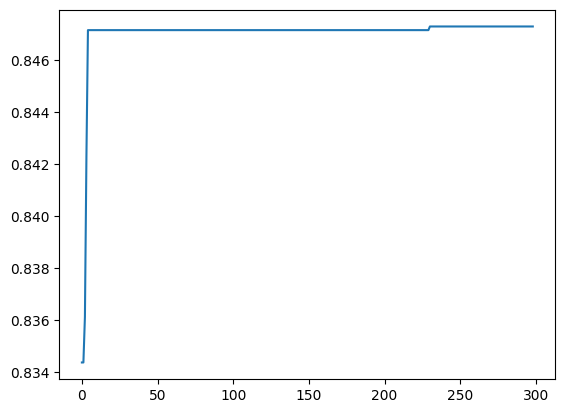

In [18]:
# how the results improved over the iterations
def plot_bestHistory(results):
    bestHistory = []
    for k in range(1,len(results)):
        bestHistory.append(np.max([y for x,y,z,v,k in sorted(results[:k], key=lambda y: y[0], reverse=True)]))
    plt.plot(bestHistory)
plot_bestHistory(results)
# probably further iterations would not significantly improve the result

In [19]:
trainResults, testResults, predictions, indices = CVTest(model='rf',
                                                        n_estimators=400, 
                                                        max_depth=4,
                                                        max_features=5,
                                                        min_samples_split=3, 
                                                        min_samples_leaf=1)

RF = {
    "name":"RF",
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

### XGBoost

In [20]:
# Function for cross-validation of XGBoost
import xgboost as xgb

def CVTestXGB(df=df, features=features, nFolds = 5, randomState=409786, *args, **kwargs):   
    
    skf = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in skf.split(df,df[target]):

        dtrain = xgb.DMatrix(df.iloc[train][features].values, df.iloc[train][target].values, feature_names=df.iloc[train][features].columns.values)
        dvalid = xgb.DMatrix(df.iloc[test][features].values, df.iloc[test][target].values, feature_names=df.iloc[test][features].columns.values)
        evals = [(dtrain, 'train'), (dvalid, 'valid')]

        gbm = xgb.train(params, dtrain, evals=evals, verbose_eval=False, *args, **kwargs)
    
        predsTrain = gbm.predict(dtrain, iteration_range = (0, gbm.best_iteration+1) )
        preds = gbm.predict(dvalid, iteration_range = (0, gbm.best_iteration+1) ) 
        
        predictions.append(preds.tolist().copy())
        indices.append(df.iloc[test].index.tolist().copy())
        
        trainScore = roc_auc_score(df[target].iloc[train]==1, predsTrain)
        testScore = roc_auc_score(df[target].iloc[test]==1, preds)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
    return trainResults, testResults, predictions, indices

In [21]:
params = {
        'eta':0.3, # learning rate
        'max_depth':6, # maximum depth of the trees
        'subsample':1, # fraction of observations used for each tree
        'colsample_bytree':1, # fraction of features used for each tree
        'colsample_bylevel':1, # fraction of features when every new new level is reached
        'lambda':1, # L2 regularization 
        'alpha':0, # L1 regularization
        'gamma':0, # minimum loss reduction
        'min_child_weight':1, # minimum sum by subtree
        # 'rate_drop':0.1, # a fraction of previous trees to drop during the dropout (Dart)
        # 'skip_drop':0.5, # probability of skipping the dropout procedure during a boosting iteration (Dart)
        'eval_metric': ["auc"],
        'objective': 'binary:logistic',
        'seed':409786,
        'booster':'gbtree',
        'tree_method':'exact',
        'grow_policy':'depthwise',
        'verbosity':1
}

trainResults, testResults, predictions, indices = CVTestXGB(params=params,num_boost_round = 999,early_stopping_rounds = 20)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults)-np.mean(testResults), np.std(testResults))

0.9993834828617437 0.8551728505048388 0.1442106323569049 0.027827683001439073


<p style='text-align: justify;'>For the default settings, the algorithm is clearly overtrained. Again, the number of parameters is so large that their sequential calibration probably will not bring good results. However, it can be used to determine approximate ranges for hyperparameters. Note that due to the small sample size, the results may be quite sensitive to seed changes.

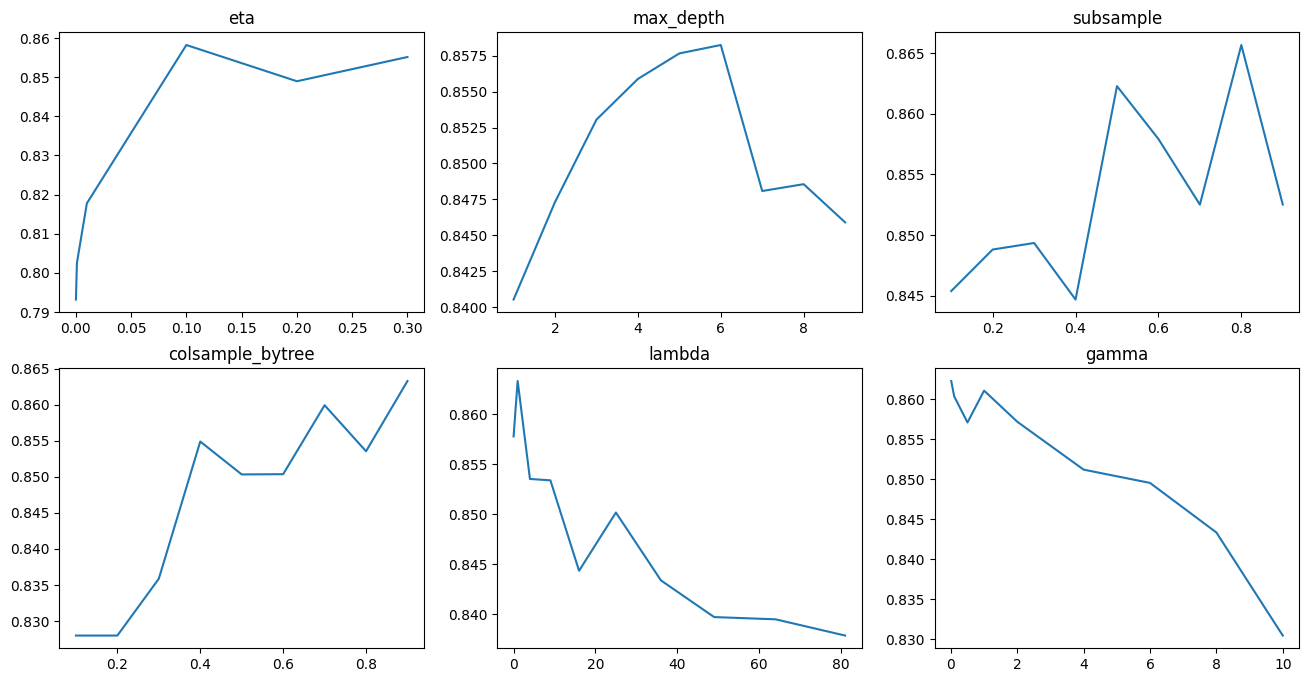

In [22]:
eta, max_depth, subsample, colsample_bytree, Lambda, gamma = ([] for i in range(6))
results = [eta, max_depth, subsample, colsample_bytree, Lambda, gamma]
names = ['eta', 'max_depth', 'subsample', 'colsample_bytree', 'lambda', 'gamma']
ranges = {
        'eta':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        'max_depth':range(1,10),
        'subsample':[x*0.1 for x in range(1, 10)],
        'colsample_bytree':[x*0.1 for x in range(1, 10)],
        'lambda':[x**2 for x in range(0,10)],
        'gamma':[0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10]
        }
plot_number = 1

fig = plt.figure(figsize=(16,8))
for res,name in zip(results,names):
    rang = ranges[name]
    for x in rang:
        params[name] = x
        trainResults, testResults, predictions, indices = CVTestXGB(params=params,num_boost_round = 999, early_stopping_rounds = 20)
        res.append([np.mean(testResults),x])
    params[name] = sorted(res, key=lambda y: y[0], reverse=True)[0][1] # sequentially set the parameter value to the one for which the best result is obtained 
    plt.subplot(2, 3, plot_number)
    plt.plot(rang, list(zip(*res))[0])
    plt.title(name)
    plot_number+=1

##### Random search in the areas suggested by the charts above
For the project I calibrate only the most important parameters.

In [23]:
results=[]
paramList = []
for i in range(1000):
    par = (random.uniform(0.05, 0.2), random.randint(3, 7), random.uniform(0.5, 0.8), random.uniform(0.4, 0.8), random.uniform(1, 9), random.uniform(0.5, 2))
    params['eta'] = par[0]
    params['max_depth'] = par[1]
    params['subsample'] = par[2]
    params['colsample_bytree'] = par[3]
    params['lambda'] = par[4]
    params['gamma'] = par[5]
    
    trainResults, testResults, predictions, indices = CVTestXGB(params=params,num_boost_round = 999, early_stopping_rounds = 20)
    results.append((np.mean(trainResults), np.mean(testResults), np.mean(trainResults)-np.mean(testResults), np.std(testResults), params.copy()))

The second set of parameters performs well on the validation sample,  does not overtrain the model and has a low variance between folds which is especially important in the case of XGBoost.

In [24]:
for i in (sorted(results, key=lambda x: x[1], reverse=True)[:3]):
    print(i)
params = sorted(results, key=lambda x: x[1], reverse=True)[1][-1]

(0.9922021229338049, 0.8674203219438912, 0.12478180098991376, 0.022170727323622273, {'eta': 0.18862832278809533, 'max_depth': 7, 'subsample': 0.6986164755974192, 'colsample_bytree': 0.627228710898266, 'colsample_bylevel': 1, 'lambda': 1.3753729094703546, 'alpha': 0, 'gamma': 0.9538214226420962, 'min_child_weight': 1, 'eval_metric': ['auc'], 'objective': 'binary:logistic', 'seed': 409786, 'booster': 'gbtree', 'tree_method': 'exact', 'grow_policy': 'depthwise', 'verbosity': 1})
(0.9548576556031338, 0.8649216757502707, 0.08993597985286317, 0.01840672980087185, {'eta': 0.1772101382222755, 'max_depth': 3, 'subsample': 0.54709202054425, 'colsample_bytree': 0.5463873077536018, 'colsample_bylevel': 1, 'lambda': 2.179071700587957, 'alpha': 0, 'gamma': 0.6460433168950455, 'min_child_weight': 1, 'eval_metric': ['auc'], 'objective': 'binary:logistic', 'seed': 409786, 'booster': 'gbtree', 'tree_method': 'exact', 'grow_policy': 'depthwise', 'verbosity': 1})
(0.9524027681363642, 0.8646012385144815, 0

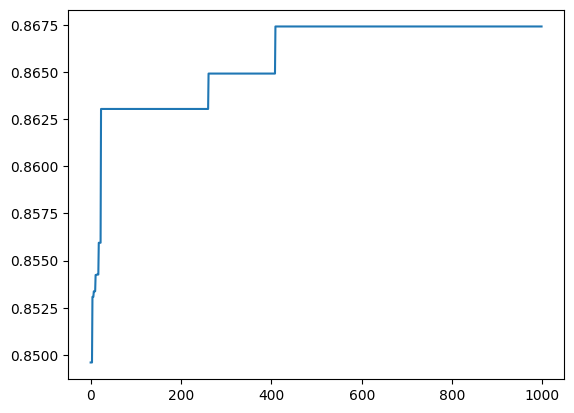

In [25]:
plot_bestHistory(results) # probably further iterations would not significantly improve the result

In [26]:
trainResults, testResults, predictions, indices = CVTestXGB(params=params,num_boost_round = 999,early_stopping_rounds = 20)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults)-np.mean(testResults), np.std(testResults),end='\n\n')

XGB = {
    "name":"XGB",
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9548576556031338 0.8649216757502707 0.08993597985286317 0.01840672980087185



### Stacking
As it often turns out that the best result can be obtained by combining the predictions from all models.

In [27]:
predNames = []
for result in [kNN, SVM, RF, XGB]:
    # combining predictions from individual folds with indices
    pred = pd.Series(sum(result['predictions'], []), index=sum(result['indices'], [])).sort_index()
    Name = (result['name'])
    predNames.append(f'pred_{Name}')
    df[f'pred_{Name}'] = pred

Combining models using logistic regression

In [28]:
import statsmodels.api as sm
mod = sm.GLM.from_formula(formula='Duda_majority ~ pred_kNN + pred_SVM + pred_RF + pred_XGB',
                          data=df, family=sm.families.Binomial())
res = mod.fit()
predsStack = res.predict()
df['pred_stack'] = predsStack
df.head()

,poviat,unemployment,age,feminization,services,retirees,soc_assistance,marriages,city,working_age,Duda_majority,pred_kNN,pred_SVM,pred_RF,pred_XGB,pred_stack
0,aleksandrowski,12.2,42.1,106,36.716838,18.437875,525.671998,0.133204,0,60.5,1,0.392857,0.186570,0.243242,0.226264,0.210112
1,augustowski,9.7,41.7,104,20.894066,17.837708,342.973355,0.139371,0,61.6,1,0.857143,0.911344,0.827320,0.760305,0.876816
2,bartoszycki,17.3,41.8,105,29.564193,17.212699,827.241350,0.145323,0,61.4,0,0.500000,0.445311,0.625567,0.559353,0.462240
3,bełchatowski,4.9,40.4,104,24.495302,15.518847,407.268608,0.144885,0,61.5,1,0.642857,0.639711,0.710458,0.541771,0.565429
4,będziński,5.4,44.2,110,30.675332,21.004261,342.662345,0.129152,0,58.4,0,0.392857,0.219316,0.267121,0.236961,0.209132


##### This model seems to be the best predictor
Finally, we managed to raise the result to roc_auc at the level of 0.866, which in the case of this dataset I consider a good result

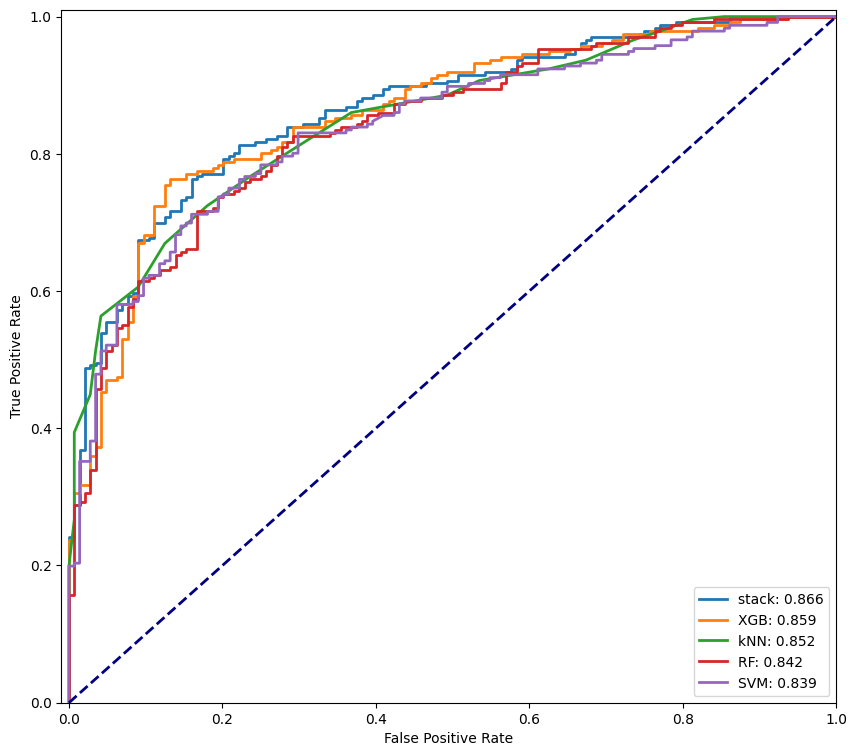

In [29]:
fig, ax = plt.subplots(figsize=(10,9))

for pred in ['pred_stack','pred_XGB','pred_kNN','pred_RF','pred_SVM']:
    
    fpr, tpr, thresholds = roc_curve(df['Duda_majority'], df[pred])
    rocScore = roc_auc_score(df['Duda_majority'], df[pred])
    rocScore = round(rocScore, 3)

    ax.plot(fpr, tpr, lw=2, label=f'{pred}: {rocScore}'.replace('pred_',''))
    
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([-0.01, 1.0])
ax.set_ylim([0.0, 1.01])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')
plt.show()